In [1]:
import numpy as np
import glob
import cv2

import matplotlib.pyplot as plt

import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [2]:
train_tiff1 = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/Image1/*')
train_tiff2 = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/Image2/*')
train_label = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/label1/*')

train_tiff1.sort()
train_tiff2.sort()
train_label.sort()

In [3]:
test_tiff1 = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛测试集/Image1/*')
test_tiff2 = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛测试集/Image2/*')

test_tiff1.sort()
test_tiff2.sort()

([], [])

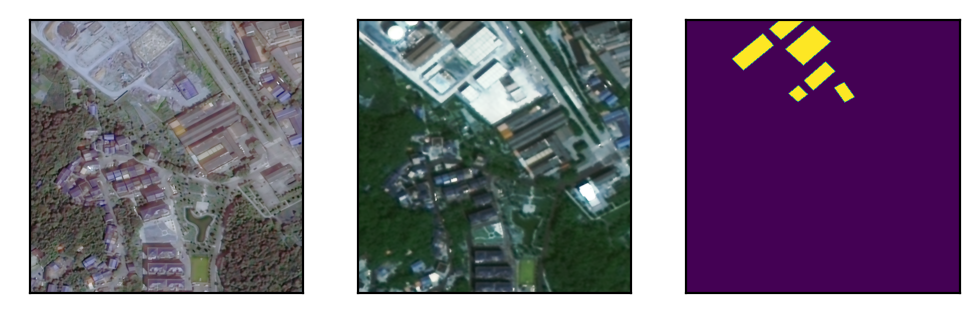

In [20]:
idx = 120
img1 = cv2.imread(train_tiff1[idx])
img2 = cv2.imread(train_tiff2[idx])
label = cv2.imread(train_label[idx])

plt.figure(dpi=200)
plt.subplot(131)
plt.imshow(img1)
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(img2)
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(label[:, :, 1] * 128)
plt.xticks([]); plt.yticks([])


In [5]:
train_tiff1[idx], train_tiff2[idx], train_label[idx]

('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/Image1/1223.tif',
 './高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/Image2/1223.tif',
 './高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/label1/1223.png')

In [137]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=6,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [76]:
DATA_CACHE = {}
class XunFeiDataset(Dataset):
    def __init__(self, tiff1_path, tiff2_path, label_path, transform=None):
        self.tiff1_path = tiff1_path
        self.tiff2_path = tiff2_path
        self.label_path = label_path

        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        if self.tiff1_path[index] in DATA_CACHE:
            img1 = DATA_CACHE[self.tiff1_path[index]]
            img2 = DATA_CACHE[self.tiff2_path[index]]
            label = DATA_CACHE[self.label_path[index]]

        else:
            img1 = cv2.imread(self.tiff1_path[index])
            img2 = cv2.imread(self.tiff2_path[index])
            label = cv2.imread(self.label_path[index])
            # label = cv2.resize(label, (256, 256))
            
            DATA_CACHE[self.tiff1_path[index]] = img1
            DATA_CACHE[self.tiff2_path[index]] = img2
            DATA_CACHE[self.label_path[index]] = label
            
        if np.random.randint(10) > 5:
            img = np.dstack([img1, img2])
            # img = img1 - img2
        else:
            img = np.dstack([img2, img1])
            # img = img2 - img1

        if self.transform is not None:
            result = self.transform(image = img, mask=label)
            img = result['image']
            label = result['mask']
            
        img = img.transpose([2,0,1])
        label = label.transpose([2,0,1])
        return img, torch.from_numpy(label).long()
    
    def __len__(self):
        return len(self.tiff1_path)

In [143]:
import albumentations as A

train_dataset = XunFeiDataset(
    train_tiff1[:-500], train_tiff2[:-500], train_label[:-500],
    A.Compose([
    A.RandomRotate90(),
        # A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.RandomContrast(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Blur(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406, 0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225,0.229, 0.224, 0.225,))
]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=5, shuffle=True, num_workers=1, pin_memory=False
)

val_dataset = XunFeiDataset(
    train_tiff1[-500:], train_tiff2[-500:], train_label[-500:],
    A.Compose([
    # A.RandomRotate90(),
        # A.Resize(256, 256),
        # A.HorizontalFlip(p=0.5),
        # A.RandomContrast(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406, 0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225,0.229, 0.224, 0.225,))
]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=5, shuffle=True, num_workers=1, pin_memory=False
)

([], [])

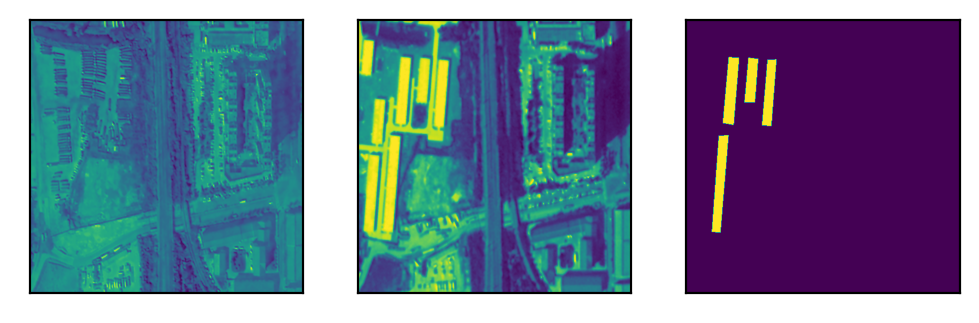

In [139]:
img, label = train_dataset[10]

plt.figure(dpi=200)
plt.subplot(131)
plt.imshow(img[0])
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(img[3])
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(label[0] * 128)
plt.xticks([]); plt.yticks([])

In [140]:
model = model.to('cuda')
# criterion = nn.CrossEntropyLoss().cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [144]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)
        
        # compute output
        output = model(input)
        loss = criterion(output.reshape(-1, 512, 512, 1), target[:, :1, :, :].float().reshape(-1, 512, 512, 1))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 20 == 0:
            print('Train loss', loss.item(), ((output[:, 0, :, :] > -1) * target[:, 0, :, :]).sum().float() / target[:, 0, :, :].sum())
            
        train_loss += loss.item()
    
    return train_loss/len(train_loader)
            
def validate(val_loader, model, criterion):
    model.eval()
    
    val_loss = 0.0
    val_iou = 0
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output.reshape(-1, 512, 512, 1), target[:, :1, :, :].float().reshape(-1, 512, 512, 1))
            val_loss += loss.item()
            
            val_iou += ((output[:, 0, :, :] > -1) * target[:, 0, :, :]).sum() / target[:, 0, :, :].sum()
    
    output = output.data.cpu().numpy()
    target = target.data.cpu().numpy()
    
    plt.figure()
    plt.subplot(121)
    plt.imshow((output[0][0] > -1).astype(int) * 128)
    plt.xticks([]); plt.yticks([])

    plt.subplot(122)
    plt.imshow((target[0][0]).astype(int) * 128)
    plt.xticks([]); plt.yticks([])
    plt.show()
    
    return val_loss / len(val_loader), val_iou / len(val_loader)

Train loss 0.5868120789527893 tensor(0.8403, device='cuda:0')
Train loss 0.19630204141139984 tensor(0.0427, device='cuda:0')
Train loss 0.15530237555503845 tensor(0.0069, device='cuda:0')
Train loss 0.2651227116584778 tensor(0.3042, device='cuda:0')
Train loss 0.2362074851989746 tensor(0.1280, device='cuda:0')
Train loss 0.10270019620656967 tensor(0.1085, device='cuda:0')
Train loss 0.13410162925720215 tensor(0.0456, device='cuda:0')
Train loss 0.33556947112083435 tensor(0., device='cuda:0')
Train loss 0.21219578385353088 tensor(0.1217, device='cuda:0')
Train loss 0.11017388105392456 tensor(0.3955, device='cuda:0')
Train loss 0.12263717502355576 tensor(0.1067, device='cuda:0')
Train loss 0.13351845741271973 tensor(0.1172, device='cuda:0')
Train loss 0.23029473423957825 tensor(0.0021, device='cuda:0')
Train loss 0.10000260919332504 tensor(0., device='cuda:0')
Train loss 0.08000857383012772 tensor(0.0537, device='cuda:0')
Train loss 0.10466621071100235 tensor(2.9781e-05, device='cuda:0')

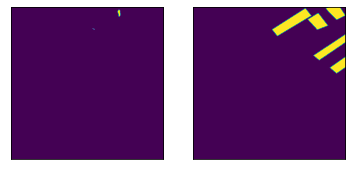

0.1666695185098797 0.14549147464334966 tensor(0.1875, device='cuda:0')
Train loss 0.12532232701778412 tensor(0.2045, device='cuda:0')
Train loss 0.1225409284234047 tensor(0., device='cuda:0')
Train loss 0.10767891258001328 tensor(0., device='cuda:0')
Train loss 0.12287860363721848 tensor(0.1068, device='cuda:0')
Train loss 0.2022818773984909 tensor(0.0050, device='cuda:0')
Train loss 0.23204314708709717 tensor(0.1000, device='cuda:0')
Train loss 0.13556645810604095 tensor(0., device='cuda:0')
Train loss 0.24754014611244202 tensor(0.0411, device='cuda:0')
Train loss 0.14234915375709534 tensor(0.3206, device='cuda:0')
Train loss 0.19388622045516968 tensor(0.2181, device='cuda:0')
Train loss 0.10558545589447021 tensor(0.6571, device='cuda:0')
Train loss 0.14346614480018616 tensor(0.0482, device='cuda:0')
Train loss 0.17505042254924774 tensor(0.0333, device='cuda:0')
Train loss 0.09362014383077621 tensor(0.0033, device='cuda:0')
Train loss 0.13918733596801758 tensor(0.0623, device='cuda:0'

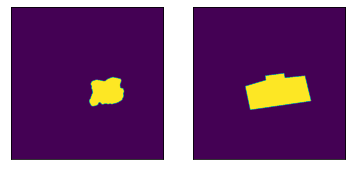

0.14816094969399274 0.12293620463460683 tensor(0.2083, device='cuda:0')
Train loss 0.09664302319288254 tensor(0.2340, device='cuda:0')
Train loss 0.13790801167488098 tensor(0.0867, device='cuda:0')
Train loss 0.1180485412478447 tensor(0.3608, device='cuda:0')
Train loss 0.09139467775821686 tensor(0.0003, device='cuda:0')
Train loss 0.0802428349852562 tensor(0.2575, device='cuda:0')
Train loss 0.08017631620168686 tensor(0.0310, device='cuda:0')
Train loss 0.20907644927501678 tensor(0.0233, device='cuda:0')
Train loss 0.13619016110897064 tensor(0.3936, device='cuda:0')
Train loss 0.15563039481639862 tensor(0., device='cuda:0')
Train loss 0.1256103515625 tensor(0.4232, device='cuda:0')
Train loss 0.31226545572280884 tensor(0.0987, device='cuda:0')
Train loss 0.09408289194107056 tensor(0.2538, device='cuda:0')
Train loss 0.0733095332980156 tensor(0.7571, device='cuda:0')
Train loss 0.08670476824045181 tensor(0.0016, device='cuda:0')
Train loss 0.0668925791978836 tensor(0.7478, device='cuda

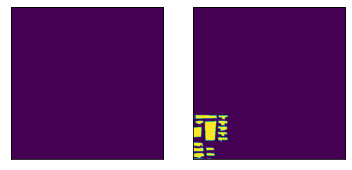

0.1428384637553245 0.12480140373110771 tensor(0.1619, device='cuda:0')
Train loss 0.09434377402067184 tensor(0.0215, device='cuda:0')
Train loss 0.07694458216428757 tensor(0.3107, device='cuda:0')
Train loss 0.11299818009138107 tensor(0.6906, device='cuda:0')
Train loss 0.08540770411491394 tensor(0.2151, device='cuda:0')
Train loss 0.5123775601387024 tensor(0.0472, device='cuda:0')
Train loss 0.13062283396720886 tensor(0.1212, device='cuda:0')
Train loss 0.10219850391149521 tensor(0.2946, device='cuda:0')
Train loss 0.09770119935274124 tensor(0.1361, device='cuda:0')
Train loss 0.05965116247534752 tensor(0.0600, device='cuda:0')
Train loss 0.0989832803606987 tensor(0.4578, device='cuda:0')
Train loss 0.16985981166362762 tensor(0.0298, device='cuda:0')
Train loss 0.12043266743421555 tensor(0.4659, device='cuda:0')
Train loss 0.09087611734867096 tensor(0.0560, device='cuda:0')
Train loss 0.18035316467285156 tensor(0.1941, device='cuda:0')
Train loss 0.0774703398346901 tensor(0.5257, devi

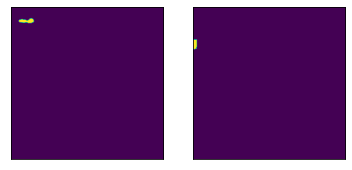

0.13889676140621304 0.12129977760836481 tensor(0.1912, device='cuda:0')
Train loss 0.09461160749197006 tensor(0.3036, device='cuda:0')
Train loss 0.09931527823209763 tensor(0.5358, device='cuda:0')
Train loss 0.4157252311706543 tensor(0.0394, device='cuda:0')
Train loss 0.18692150712013245 tensor(0., device='cuda:0')
Train loss 0.14139166474342346 tensor(0.1473, device='cuda:0')
Train loss 0.15206508338451385 tensor(0.0168, device='cuda:0')
Train loss 0.1558590680360794 tensor(0.1690, device='cuda:0')
Train loss 0.16163598001003265 tensor(0.0297, device='cuda:0')
Train loss 0.12702761590480804 tensor(0.1442, device='cuda:0')
Train loss 0.1759624481201172 tensor(0.2510, device='cuda:0')
Train loss 0.12942522764205933 tensor(0.1085, device='cuda:0')
Train loss 0.08607803285121918 tensor(0.5180, device='cuda:0')
Train loss 0.23740577697753906 tensor(0.0062, device='cuda:0')
Train loss 0.3473646938800812 tensor(0.1636, device='cuda:0')
Train loss 0.13503584265708923 tensor(0.4861, device='

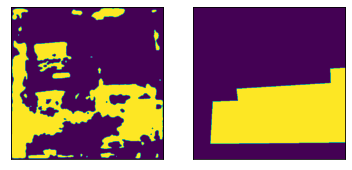

0.13701617606915534 0.13617658082395792 tensor(0.3649, device='cuda:0')
Train loss 0.28421518206596375 tensor(0.2612, device='cuda:0')
Train loss 0.13376589119434357 tensor(0.1878, device='cuda:0')
Train loss 0.10799107700586319 tensor(0.3892, device='cuda:0')
Train loss 0.10601416975259781 tensor(0.7085, device='cuda:0')
Train loss 0.12116658687591553 tensor(0.1523, device='cuda:0')
Train loss 0.1340187042951584 tensor(0.1271, device='cuda:0')
Train loss 0.09261777251958847 tensor(0.4337, device='cuda:0')
Train loss 0.09590116888284683 tensor(0.2135, device='cuda:0')
Train loss 0.09631206840276718 tensor(0.4137, device='cuda:0')
Train loss 0.149620920419693 tensor(0.2873, device='cuda:0')
Train loss 0.16965420544147491 tensor(0.4986, device='cuda:0')
Train loss 0.05797718092799187 tensor(0.6216, device='cuda:0')
Train loss 0.09747645258903503 tensor(0.3965, device='cuda:0')
Train loss 0.15556927025318146 tensor(0.1571, device='cuda:0')
Train loss 0.0836724042892456 tensor(0.2452, devi

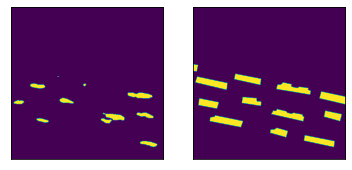

0.13082824756391345 0.1113160197623074 tensor(0.3483, device='cuda:0')
Train loss 0.06539076566696167 tensor(0.5366, device='cuda:0')
Train loss 0.12456619739532471 tensor(0.6185, device='cuda:0')
Train loss 0.07540901005268097 tensor(0.5054, device='cuda:0')
Train loss 0.08910316228866577 tensor(0.4659, device='cuda:0')
Train loss 0.12738768756389618 tensor(0.5152, device='cuda:0')
Train loss 0.12278004735708237 tensor(0.5393, device='cuda:0')
Train loss 0.09067904204130173 tensor(0.4115, device='cuda:0')
Train loss 0.08707904070615768 tensor(0.5030, device='cuda:0')
Train loss 0.10781611502170563 tensor(0.4614, device='cuda:0')
Train loss 0.12378519028425217 tensor(0.5481, device='cuda:0')
Train loss 0.07729856669902802 tensor(0.4922, device='cuda:0')
Train loss 0.08202244341373444 tensor(0.0675, device='cuda:0')
Train loss 0.2003326714038849 tensor(0.0829, device='cuda:0')
Train loss 0.21152038872241974 tensor(0.2649, device='cuda:0')
Train loss 0.07640626281499863 tensor(0.5225, de

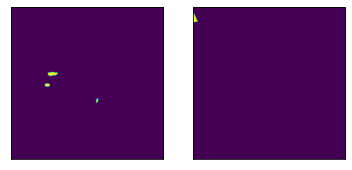

0.12735300352796913 0.10652388319373131 tensor(0.4418, device='cuda:0')
Train loss 0.06658961623907089 tensor(0.2665, device='cuda:0')
Train loss 0.14216820895671844 tensor(0.4323, device='cuda:0')
Train loss 0.05975150689482689 tensor(0.8300, device='cuda:0')
Train loss 0.20094318687915802 tensor(0.3822, device='cuda:0')
Train loss 0.08663441985845566 tensor(0.5421, device='cuda:0')
Train loss 0.11133750528097153 tensor(0.2973, device='cuda:0')
Train loss 0.07450415194034576 tensor(0.5768, device='cuda:0')
Train loss 0.11425609886646271 tensor(0.2545, device='cuda:0')
Train loss 0.07430019229650497 tensor(0.4691, device='cuda:0')
Train loss 0.051134515553712845 tensor(0.6338, device='cuda:0')
Train loss 0.11946600675582886 tensor(0.1679, device='cuda:0')
Train loss 0.09731558710336685 tensor(0.5625, device='cuda:0')
Train loss 0.08830208331346512 tensor(0.4031, device='cuda:0')
Train loss 0.05853591114282608 tensor(0.5335, device='cuda:0')
Train loss 0.17950615286827087 tensor(0.3658,

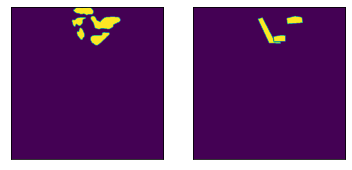

0.12284374492242932 0.10100362915545702 tensor(0.4938, device='cuda:0')
Train loss 0.06888668984174728 tensor(0.6869, device='cuda:0')
Train loss 0.18222132325172424 tensor(0.3222, device='cuda:0')
Train loss 0.11553261429071426 tensor(0.4549, device='cuda:0')
Train loss 0.105146624147892 tensor(0.4607, device='cuda:0')
Train loss 0.0863155946135521 tensor(0.4848, device='cuda:0')
Train loss 0.09278720617294312 tensor(0.3528, device='cuda:0')
Train loss 0.06138972193002701 tensor(0.6189, device='cuda:0')
Train loss 0.0723676010966301 tensor(0.7355, device='cuda:0')
Train loss 0.07388739287853241 tensor(0.2893, device='cuda:0')
Train loss 0.08165993541479111 tensor(0.4024, device='cuda:0')
Train loss 0.10107304900884628 tensor(0.0918, device='cuda:0')
Train loss 0.2412377893924713 tensor(0.2020, device='cuda:0')
Train loss 0.12980829179286957 tensor(0.4623, device='cuda:0')
Train loss 0.10390104353427887 tensor(0.2123, device='cuda:0')
Train loss 0.17385952174663544 tensor(0.4285, devic

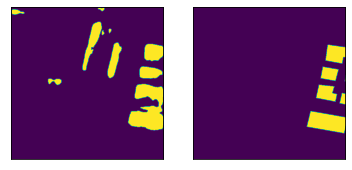

0.1241641279682517 0.12032756749540567 tensor(0.6375, device='cuda:0')
Train loss 0.12886086106300354 tensor(0.2505, device='cuda:0')
Train loss 0.05699033662676811 tensor(0.4033, device='cuda:0')
Train loss 0.14408421516418457 tensor(0.1187, device='cuda:0')
Train loss 0.07688136398792267 tensor(0.3760, device='cuda:0')
Train loss 0.13295674324035645 tensor(0.1952, device='cuda:0')
Train loss 0.11638827621936798 tensor(0.7072, device='cuda:0')
Train loss 0.1748327761888504 tensor(0.4705, device='cuda:0')
Train loss 0.11925637722015381 tensor(0.4594, device='cuda:0')
Train loss 0.10365535318851471 tensor(0.2817, device='cuda:0')
Train loss 0.09436485171318054 tensor(0.6136, device='cuda:0')
Train loss 0.07400764524936676 tensor(0.6254, device='cuda:0')
Train loss 0.0837186947464943 tensor(0.4462, device='cuda:0')
Train loss 0.06993632018566132 tensor(0.4769, device='cuda:0')
Train loss 0.10873173922300339 tensor(0.0695, device='cuda:0')
Train loss 0.13888031244277954 tensor(0.3544, dev

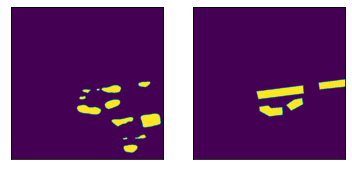

0.12047086430713534 0.10146194633096456 tensor(0.4263, device='cuda:0')


In [145]:
for _  in range(10):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_loss, val_iou = validate(val_loader, model, criterion)
    
    print(train_loss, val_loss, val_iou)

In [146]:
test_dataset = XunFeiDataset(
    test_tiff1[:], test_tiff2[:], test_tiff1[:],
    A.Compose([
    # A.RandomRotate90(),
        # A.Resize(256, 256),
        # A.HorizontalFlip(p=0.5),
        # A.RandomContrast(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406, 0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225, 0.229, 0.224, 0.225))
]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=5, shuffle=False, num_workers=1, pin_memory=False
)

In [148]:
model.eval()
test_pred = []
with torch.no_grad():
    for i, (input, target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        output = output.data.cpu().numpy()
        
        output = (output[:, 0, :, :] > -1).astype(int)
        test_pred.append(output)

In [149]:
test_pred = np.vstack(test_pred)

In [150]:
import os
for path, pred in zip(test_tiff1, test_pred):
    cv2.imwrite(
        os.path.join('submit', os.path.basename(path).replace('tif', 'png')),
        pred.astype(np.uint8)
    )

In [151]:
!mkdir submit

mkdir: 无法创建目录"submit": 文件已存在


In [152]:
!\rm submit.zip
!zip -r submit.zip submit

rm: 无法删除'submit.zip': 没有那个文件或目录
  adding: submit/ (stored 0%)
  adding: submit/3357.png (deflated 55%)
  adding: submit/1529.png (deflated 40%)
  adding: submit/1453.png (deflated 37%)
  adding: submit/2095.png (deflated 86%)
  adding: submit/2634.png (deflated 44%)
  adding: submit/2002.png (deflated 70%)
  adding: submit/345.png (deflated 86%)
  adding: submit/3109.png (deflated 23%)
  adding: submit/591.png (deflated 86%)
  adding: submit/2251.png (deflated 59%)
  adding: submit/1735.png (deflated 72%)
  adding: submit/1573.png (deflated 92%)
  adding: submit/2562.png (deflated 17%)
  adding: submit/1837.png (deflated 51%)
  adding: submit/92.png (deflated 67%)
  adding: submit/1101.png (deflated 61%)
  adding: submit/2637.png (deflated 41%)
  adding: submit/3113.png (deflated 36%)
  adding: submit/3130.png (deflated 12%)
  adding: submit/2454.png (deflated 40%)
  adding: submit/1600.png (deflated 57%)
  adding: submit/2822.png (deflated 55%)
  adding: submit/1449.png (deflated 77%)